<font size=7>Latencies Plot Visualizer

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, latencies, plot_vector_layout3
from human_hip.animate import animate_latencies
import human_hip.spike_data as spike_data

import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np

# hc112823

In [2]:
sd = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip" )


In [3]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc

In [4]:

def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=30, sttc_cutoff = 0.04, latency_cutoff=2.5, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
        if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
                if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
                    pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 

    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    ##Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
        max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
        cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
    cross_lag = np.array(cross_lag)
    to_keep = np.where(( cross_lag< cross_sttc_max_cutoff) & (cross_lag> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 

In [5]:
good_pairs = curate_latencies(sd)

44944 Starting Pairs
11079 pairs above sttc cutoff
752 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
205 pairs between cross_sttc cutoffs


In [11]:
##ump good pairs into 'hc112823_good_pairs.pkl'
with open( 'hc112823_acid_good_pairs.pkl', 'wb') as my_file:
    pickle.dump(good_pairs, my_file)

# with open( 'hc112823_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)
# print(len(good_pairs))

In [14]:
#len(good_pairs)

In [19]:
plot_latency_angle_hist

<function human_hip.spike_data.plot_latencies.plot_latency_angle_hist(sd, pairs, by_firing_rate=False, late_cutoff_low=1, late_cutoff_high=15)>

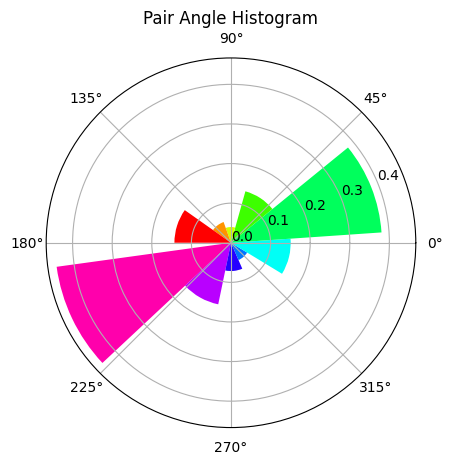

In [6]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=False, late_cutoff_high=30)

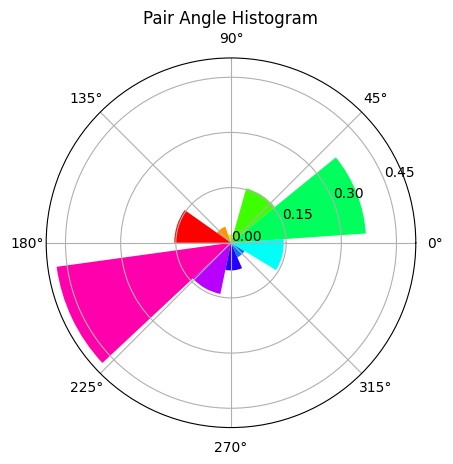

In [7]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=True, late_cutoff_high=30)

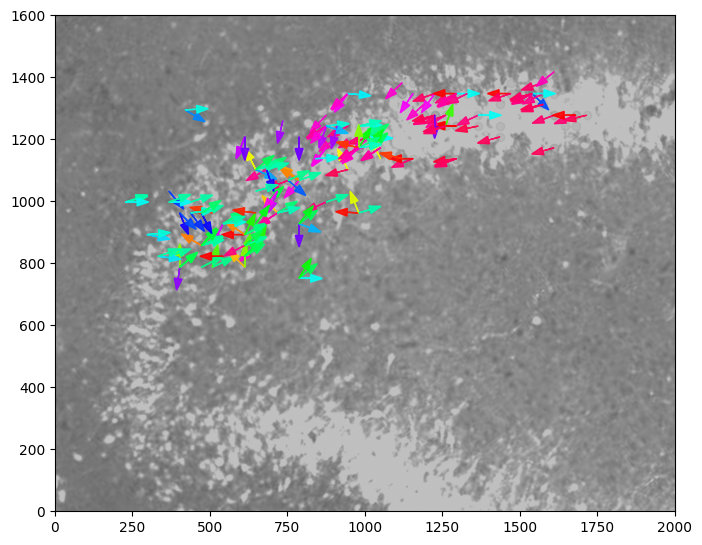

In [8]:
plot_vector_layout( sd, good_pairs,  image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

In [9]:
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
from scipy import stats


def pairs_hisogram(pairs, sd, ms_cutoff_high=30):
    @interact
    def plot_pair(pair_i = (0, len(pairs)-1) ):
        latencies_pair = latencies( pairs[pair_i,0], pairs[pair_i,1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )

pairs_hisogram( good_pairs, sd, ms_cutoff_high=30)

interactive(children=(IntSlider(value=102, description='pair_i', max=204), Output()), _dom_classes=('widget-in…

## original

In [15]:
plot_vector_layout

<function human_hip.spike_data.plot_latencies.plot_vector_layout(sd, pairs, normalize=True, plot_neuron=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None, background_color='white')>

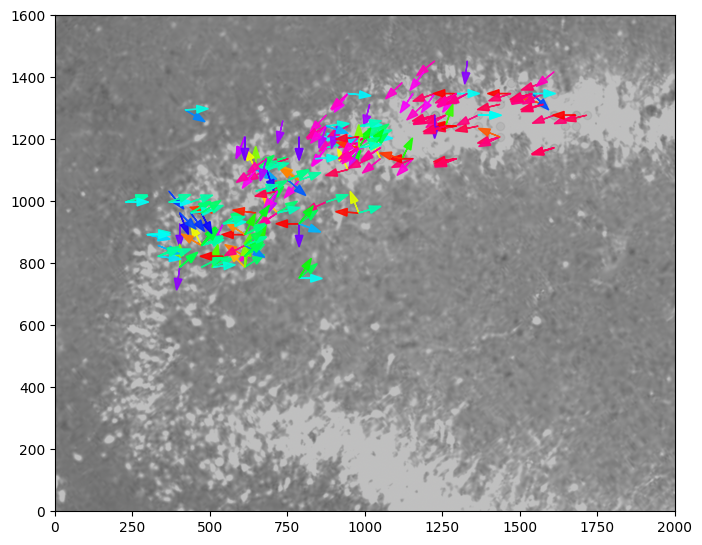

In [16]:
plot_vector_layout( sd, good_pairs,  image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

In [27]:
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
from scipy import stats

In [28]:
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
from scipy import stats

def pairs_hisogram(pairs, sd, ms_cutoff_high=30):
    @interact
    def plot_pair(pair_i = (0, len(pairs)-1) ):
        latencies_pair = latencies( pairs[pair_i,0], pairs[pair_i,1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )

pairs_hisogram( good_pairs, sd, ms_cutoff_high=30)

In [29]:
pairs_hisogram( good_pairs, sd, ms_cutoff_high=30)

interactive(children=(IntSlider(value=131, description='pair_i', max=263), Output()), _dom_classes=('widget-in…

## arrows averaged

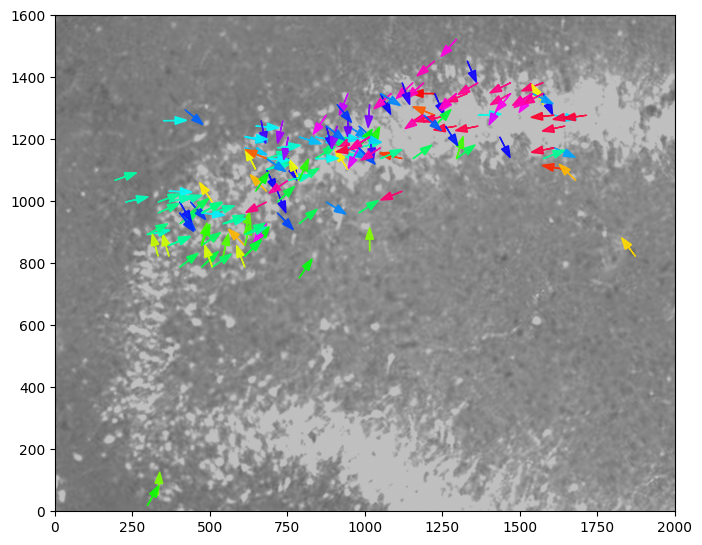

In [7]:
plot_vector_layout3( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

# <font color="blue">  Remove blue arrows

In [22]:
pairs= good_pairs
image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png"
xlim=(0,2000)
ylim=(0,1600)
figsize=(8, 8)
ms_cutoff_high=20 
se_cuttoff = .1

In [9]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact
from matplotlib.ticker import MaxNLocator
import numpy as np

In [10]:
def plot_vector_layout4( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20, se_cuttoff=.1 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count
    pairs = pairs                      # make a copy of pairs, this avoids some bug
    latencies_count = []
    for i in range(len(pairs)):
        pair_latencies = latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)
        latencies_count.append(len(pair_latencies))
        if np.median(pair_latencies)<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latencies_count[i]
        else:
            pair_dict[key] = [ angles[i] ] * latencies_count[i]

    # create new dictionary of just mean angles
    pair_angles = {}
    pair_se = {}
    for key, value in pair_dict.items():
        pair_angles[key] = sum(value) / len(value)
        pair_se[key] = np.std(value, ddof=1) / len(value)

    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    pair_removed = 0
    for pair, angle in pair_angles.items():
        if pair_se[pair] < se_cuttoff :
            angle2 = (angle*-1+ np.pi)/np.pi/2
            start = neuron_xy[ pair ]  
            arrow = FancyArrow( 
                    start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                    linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
            plt.gca().add_patch(arrow)
        else:
            pair_removed = pair_removed + 1
    print("Pairs removed by SE cutoff:", pair_removed )


/tmp/ipykernel_5287/3022591660.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_5287/3022591660.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SE cutoff: 0


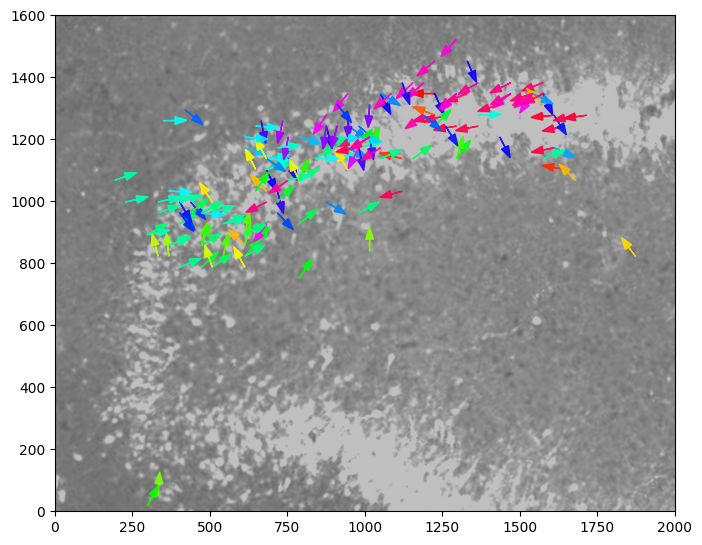

In [11]:
plot_vector_layout4( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

/tmp/ipykernel_5287/1302121889.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SE cutoff: 45


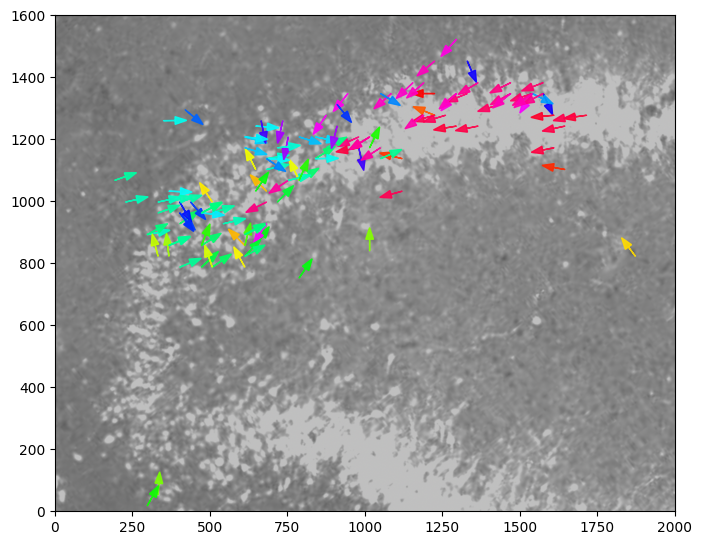

In [26]:

    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    pair_removed = 0
    for pair, angle in pair_angles.items():
        if pair_se[pair] < 1 :
            angle2 = (angle*-1+ np.pi)/np.pi/2
            start = neuron_xy[ pair ]  
            arrow = FancyArrow( 
                    start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                    linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
            plt.gca().add_patch(arrow)
        else:
            pair_removed = pair_removed + 1
    print("Pairs removed by SE cutoff:", pair_removed )


In [16]:

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count
    pairs = pairs                      # make a copy of pairs, this avoids some bug
    latencies_count = []
    for i in range(len(pairs)):
        pair_latencies = latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)
        latencies_count.append(len(pair_latencies))
        if np.median(pair_latencies)<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latencies_count[i]
        else:
            pair_dict[key] = [ angles[i] ] * latencies_count[i]

    # create new dictionary of just mean angles
    pair_angles = {}
    pair_se = {}
    for key, value in pair_dict.items():
        pair_angles[key] = sum(value) / len(value)
        pair_se[key] = np.std(value, ddof=1) #/ len(value)


/tmp/ipykernel_5287/1735045424.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


In [17]:
len(pair_se.values())

169

(array([92., 12., 11., 18., 12.,  9.,  4.,  2.,  3.,  6.]),
 array([0.        , 0.2799276 , 0.55985519, 0.83978279, 1.11971038,
        1.39963798, 1.67956558, 1.95949317, 2.23942077, 2.51934836,
        2.79927596]),
 <BarContainer object of 10 artists>)

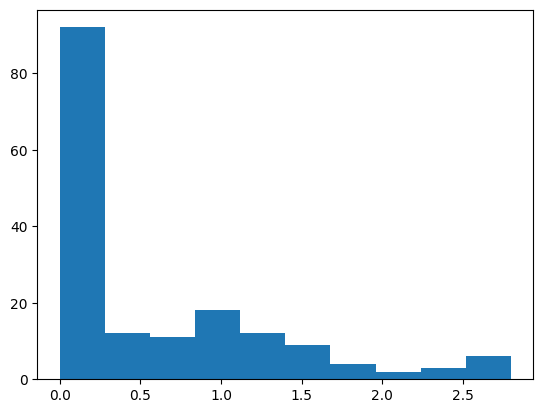

In [18]:
plt.hist( list(pair_se.values()) )

In [19]:
@interact(num=(0,35))
def angles_hist(num):
    key = list(pair_dict.keys())[num]
    print("SD:", np.std( pair_dict[key] ))
    print( "SE", np.std( pair_dict[key], ddof=1) / np.sqrt(len(pair_dict[key])) )
    plt.hist( pair_dict[key] )

interactive(children=(IntSlider(value=17, description='num', max=35), Output()), _dom_classes=('widget-interac…

## <font color="red"> FAILED-  removing extra blues 

In [6]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual
from matplotlib.ticker import MaxNLocator

In [7]:
pairs=good_pairs
image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png"
xlim=(0,2000)
ylim=(0,1600)
figsize=(8, 8)
ms_cutoff_high=20 

In [8]:

# Get the x/y locations of the start and end neurons of each pair
neuron_xy = []
for neuron in sd.neuron_data[0].values():
    neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
neuron_xy = np.array(neuron_xy)

# Latencies count
pairs = good_pairs                      # make a copy of pairs, this avoids some bug
latencies_count = []
for i in range(len(pairs)):
    pair_latencies = latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)
    latencies_count.append(len(pair_latencies))
    if np.median(pair_latencies)<0:
        pairs[i] = [ pairs[i][1], pairs[i][0] ]

starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
ends = neuron_xy[ pairs[:,1] ]
centered = ends-starts   # Get the directions of arrows, then make of of them the same length
normalized = preprocessing.normalize(centered) #* 75
angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

# clump by starting pair angle counted by angle
pair_dict = {}
for i in range(len(pairs)):
    key, value = pairs[i]
    if key in pair_dict:
        pair_dict[key] = pair_dict[key] + [ angles[i] ] * latencies_count[i]
    else:
        pair_dict[key] = [ angles[i] ] * latencies_count[i]
        


/tmp/ipykernel_782/993191322.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


(array([ 56.,   0.,   0.,   0.,   0.,   0., 101.,   0.,   0., 186.]),
 array([-0.87605805, -0.76220631, -0.64835456, -0.53450282, -0.42065107,
        -0.30679933, -0.19294758, -0.07909584,  0.03475591,  0.14860765,
         0.2624594 ]),
 <BarContainer object of 10 artists>)

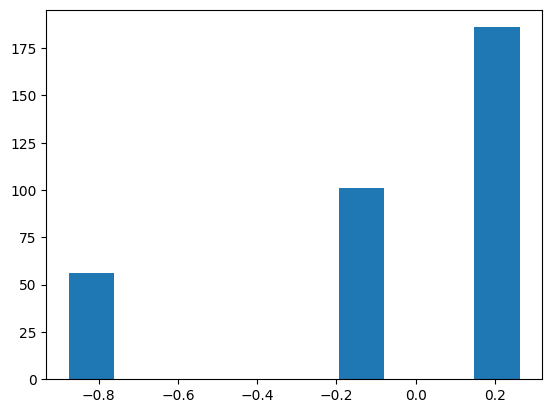

In [16]:
plt.hist(pair_dict[0])

-0.03886261717239033

In [18]:
np.mean( np.abs(pair_dict[0]) )

0.305894145131436

In [20]:
pair_dict.keys()

dict_keys([97, 117, 1, 2, 63, 183, 158, 4, 74, 80, 115, 5, 25, 48, 120, 163, 186, 6, 7, 81, 119, 171, 29, 9, 182, 189, 10, 24, 36, 12, 56, 62, 88, 13, 116, 126, 128, 32, 71, 15, 16, 190, 134, 161, 18, 99, 110, 136, 166, 19, 78, 187, 20, 34, 21, 135, 22, 66, 86, 23, 30, 52, 95, 102, 109, 148, 47, 26, 129, 27, 105, 184, 28, 138, 191, 91, 31, 146, 94, 106, 33, 200, 60, 154, 162, 165, 38, 141, 173, 39, 49, 101, 175, 194, 178, 42, 75, 104, 204, 43, 131, 199, 65, 206, 98, 50, 64, 51, 143, 53, 92, 57, 193, 58, 59, 167, 61, 90, 111, 188, 68, 70, 72, 156, 164, 151, 76, 201, 208, 79, 82, 155, 87, 209, 93, 100, 96, 169, 157, 122, 159, 130, 103, 132, 107, 108, 112, 179, 181, 127, 147, 185, 121, 195, 123, 124, 152, 137, 140, 168, 174, 144, 198, 172, 197, 207, 180])

In [10]:
pair_dict[0]

[0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.21866894587394195,
 0.2186689

In [12]:
#pair_dict_safety = pair_dict.copy()
pair_dict = pair_dict_safety.copy()

In [14]:
np.mean( pair_dict[0] )

-0.03886261717239033

In [15]:
# create new dictionary of just mean angles
#to_delete = []
#for key, value in pair_dict.items():
for key in list(pair_dict.keys()):
    print(key)
# mean angle is small but, absolute angle is large
    if np.abs(np.mean( pair_dict[key] )) < 0.5: #and np.mean(np.abs( pair_dict[key] )) > 0.3:
        # remove from dictionary
        del pair_dict[key]
    else:
        pair_dict[key] = np.mean( pair_dict[key] ) 




0
97
117
1
2
63
183
158
4
74
80
115
5
25
48
120
163
186
6
7
81
119
171
29
9
182
189
10
24
36
12
56
62
88
13
116
126
128
32
71
15
16
190
134
161
18
99
110
130
136
166
19
78
187
20
34
21
135
22
66
86
23
30
47
52
95
102
109
148
26
129
27
46
105
184
28
138
191
91
31
146
94
106
33
200
60
154
162
165
38
141
173
39
49
101
175
194
178
42
75
104
204
43
131
199
65
206
98
50
64
51
143
147
53
92
57
193
58
59
167
61
90
111
188
68
70
157
72
103
156
164
151
76
201
208
79
82
155
87
209
93
100
96
169
122
159
179
132
107
108
112
181
127
185
121
195
123
124
152
137
140
168
174
144
198
172
197
207
180


/tmp/ipykernel_782/3408538111.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


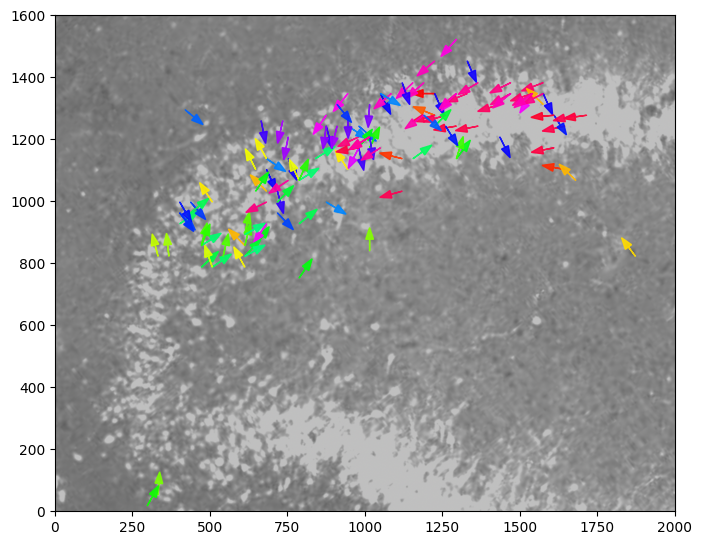

In [16]:

# Plot original scatter
plt.figure(figsize=(8, 8))
ax = plt.axes()
if image_path is not None:
    img = plt.imread(image_path)      # Load in image
    plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
plt.xlim( xlim )
plt.ylim( ylim )    

# Draw Arrows
cmap = cm.get_cmap('hsv')
for pair, angle in pair_dict.items():
    angle2 = (angle*-1+ np.pi)/np.pi/2

    start = neuron_xy[ pair ]  
    arrow = FancyArrow( 
            start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
            linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
    plt.gca().add_patch(arrow)
